In [1]:
import datashader

/home/jialingjiao/miniconda3/envs/fractal/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [2]:
from epsilon_transformers.training.configs.model_configs import RawModelConfig
from io import BytesIO
from typing import Dict, Literal
from pydantic import BaseModel, model_validator
import pathlib
import yaml
import torch
from torch.utils.data import DataLoader
from typing import Union, Optional
import wandb
import os
import dotenv
import math
from dataclasses import dataclass, asdict
from tqdm import tqdm

from epsilon_transformers.process.processes import PROCESS_REGISTRY
from epsilon_transformers.process.dataset import (
    ProcessDataset,
    process_dataset_collate_fn,
)
from epsilon_transformers.training.configs.base_config import Config
from epsilon_transformers.training.configs.model_configs import RawModelConfig
from transformer_lens import HookedTransformer
#from epsilon_transformers.training.train import _set_random_seed

In [4]:
Optimizer = Union[torch.optim.Adam, torch.optim.SGD]

class OptimizerConfig(Config):
    optimizer_type: Literal["sgd", "adam"]
    learning_rate: float
    weight_decay: float

    def from_model(self, model: torch.nn.Module, device: torch.device) -> Optimizer:
        if self.optimizer_type == "adam":
            optimizer = torch.optim.Adam
        elif self.optimizer_type == "sgd":
            optimizer = torch.optim.SGD
        else:
            raise ValueError(
                f"{self.optimizer_type} is not a valid optimizer_type. It must be either 'adam' or 'sgd'"
            )

        return optimizer(
            model.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay
        )

class ProcessDatasetConfig(Config):
    process: str
    process_params: Dict[str, float]
    batch_size: int
    num_tokens: int
    test_split: float

    def to_dataloader(self, sequence_length: int, train: bool) -> DataLoader:
        dataset = ProcessDataset(
            process_name=self.process,
            process_params=self.process_params,
            sequence_length=sequence_length,
            num_samples=(
                self.num_tokens
                if train
                else math.floor(self.num_tokens * self.test_split)
            ),
        )
        return DataLoader(
            dataset=dataset,
            collate_fn=process_dataset_collate_fn,
            batch_size=self.batch_size,
        )

@dataclass
class Log:
    train_loss: Optional[float]
    test_loss: Optional[float]
    config: "LoggingConfig"

    def reset(self):
        if self.config.train_loss:
            self.train_loss = 0.0
        else:
            self.train_loss = None

        if self.config.test_loss:
            self.test_loss = 0.0
        else:
            self.test_loss = None

    def update_metrics(self, train_or_test: Literal["train", "test"], loss: float):
        if train_or_test == "train" and self.config.test_loss:
            self.train_loss += loss
        elif train_or_test == "test" and self.config.train_loss:
            self.test_loss += loss
        else:
            raise ValueError

    def persist(self):
        if self.config.wandb:
            wandb.log({k: v for k, v in asdict(self).items() if v is not None and not isinstance(v, LoggingConfig)})
        if self.config.local is not None:
            raise NotImplementedError

class LoggingConfig(Config):
    local: Optional[pathlib.Path] = None
    wandb: bool = True
    project_name: Optional[str]
    train_loss: bool = True
    test_loss: bool = True

    def close(self):
        if self.wandb:
            wandb.finish()
        if self.local is not None:
            raise NotImplementedError

    def init(self) -> Log:
        return Log(
            config=self,
            train_loss=0.0 if self.train_loss else None,
            test_loss=0.0 if self.test_loss else None,
        )

class TrainConfig(Config):
    model: RawModelConfig
    optimizer: OptimizerConfig
    dataset: ProcessDatasetConfig
    logging: LoggingConfig
    seed: int
    verbose: bool

    @model_validator(mode='after')
    def validate_model(self):
        dataset_process = self.dataset.process
        if dataset_process:
            process_vocab_len = PROCESS_REGISTRY[dataset_process]().vocab_len
            if self.model.d_vocab != process_vocab_len:
                raise ValueError(f"Model's d_vocab ({self.model.d_vocab}) doesn't match dataset process's vocab_len ({process_vocab_len})")
        return self

    def init_logger(self) -> Log:
        if self.logging.wandb:
            dotenv.load_dotenv()
            wandb_api_key = os.environ.get("WANDB_API_KEY", None)
            if wandb_api_key is None:
                raise ValueError(
                    "To use wandb, set your API key as the environment variable `WANDB_API_KEY`"
                )

            wandb.login(key=wandb_api_key)
            wandb.init(project=self.logging.project_name, config=self.model_dump())
        if self.logging.local is not None:
            raise NotImplementedError()
        return self.logging.init()

In [5]:
print(f"{torch.cuda.get_device_name()}")
print(f'available devices: {torch.cuda.device_count()}')
print(f'current device: {torch.cuda.current_device()}')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

NVIDIA A40
available devices: 1
current device: 0
cuda


In [6]:
import random
import numpy as np
def _set_random_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def _calculate_tokens_trained(
    batch_size: int,
    sequence_len: int,
    batch_idx: int,
) -> int:
    tokens_per_batch = batch_size * sequence_len
    total_tokens_trained = (batch_idx + 1) * tokens_per_batch
    return total_tokens_trained


def _check_if_action_batch(
    perform_action_every_n_tokens: int,
    batch_size: int,
    sequence_len: int,
    batch_idx: int,
) -> bool:
    tokens_per_batch = batch_size * sequence_len
    assert (
        perform_action_every_n_tokens >= tokens_per_batch
    ), "perform_action_every_n_tokens must be greater than or equal to tokens_per_batch"
    perform_action_every_n_batches = perform_action_every_n_tokens // tokens_per_batch
    return (batch_idx + 1) % perform_action_every_n_batches == 0


In [7]:
def train_model(config: TrainConfig) -> HookedTransformer:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    _set_random_seed(config.seed)

    model = config.model.to_hooked_transformer(device=device, seed=config.seed)
    optimizer = config.optimizer.from_model(model=model, device=device)
    train_dataloader = config.dataset.to_dataloader(
        sequence_length=model.cfg.n_ctx, train=True
    )
    
    log = config.init_logger()
    model.train()
    for input_data, target_data in tqdm(train_dataloader, desc="Train Loop"):
        input_data, target_data = input_data.to(device), target_data.to(device)
        optimizer.zero_grad()
        loss = model(input_data, return_type="loss")
        log.update_metrics(train_or_test="train", loss=loss.item())
        loss.backward()
        optimizer.step()

    model.eval()
    return model

# Replicate Results

In [14]:
model_config = RawModelConfig(
    d_vocab=3,
    d_model=64,
    n_ctx=10,
    d_head=8,
    n_head=1,
    d_mlp=12,
    n_layers=4,
)

optimizer_config = OptimizerConfig(
    optimizer_type='sgd',
    learning_rate=1e-2,
    weight_decay=0
)

dataset_config = ProcessDatasetConfig(
    process='Mess3',
    process_params={'x': 0.5, 'a': 0.85},
    batch_size=64,
    num_tokens=50000,
    test_split=0.15
)

mock_config = TrainConfig(
    model=model_config,
    optimizer=optimizer_config,
    dataset=dataset_config,
    logging=LoggingConfig(project_name="lucas-mess3-test", wandb=True),
    verbose=True,
    seed=42
)

In [ ]:
model = train_model(mock_config)

In [10]:
from epsilon_transformers.process.processes import Mess3
from epsilon_transformers.analysis.activation_analysis import find_msp_subspace_in_residual_stream

process = Mess3()

ground_truth_belief_states_reshaped, predicted_beliefs = find_msp_subspace_in_residual_stream(model=model, process=process, num_sequences=10)

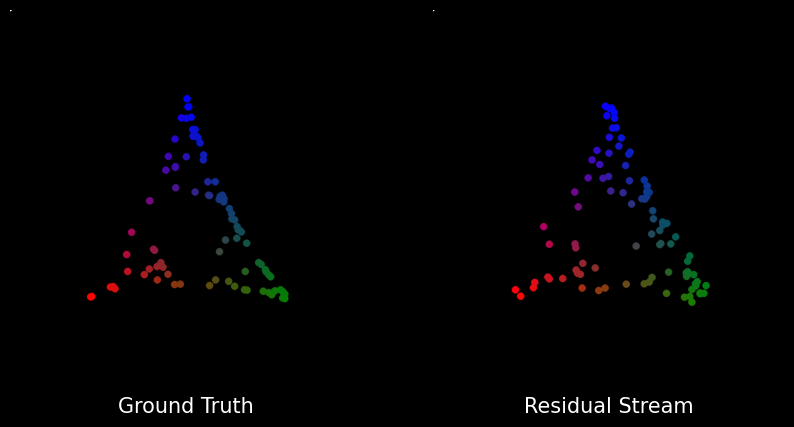

In [11]:
from epsilon_transformers.visualization.plots import plot_ground_truth_and_evaluated_2d_simplex


fig = plot_ground_truth_and_evaluated_2d_simplex(ground_truth_tensor=ground_truth_belief_states_reshaped, predicted_beliefs=predicted_beliefs, plot_triangles=True, facecolor='black', px=10)
fig.show()